### This example uses TensorFlow to sample from a distribution of a mixture model of 10 2D Gaussians

A Gaussian distribution $X\sim N(\mu, \Sigma)$ can be sampled by $X = \mu + EZ$, where $Z\sim N(0, I)$ and $\Sigma=EE^T$. This is called **Cholesky decomposition** if $E$ is a triangular matrix. X can also be sampled by $X = \mu + U^T\Lambda^{\frac{1}{2}}Z$, where 
$Z\sim N(0, I)$, and $\Sigma=U^T\Lambda{U}$, which is the **eigen decomposition**. Note that decomposition is not unique.

In [1]:
import tensorflow as tf
import tensorflow.contrib.distributions as ds
import matplotlib.pyplot as plt
import math
%matplotlib inline

First draw a density plot of 2D Gaussian, a Multivariate Gaussian distribution in TensorFlow is specified by its mean and triangular scale matrix. Class **tf.contrib.distributions.MultivariateNormalTriL**

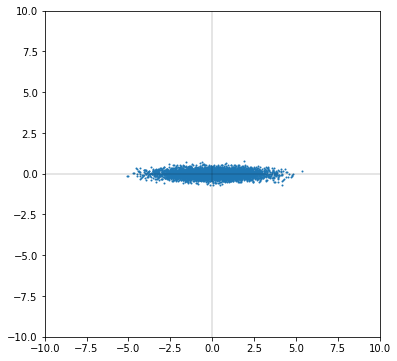

In [2]:
# Specifiy mu and cov
mu = [0., 0.]
cov = [[2.5, 0.],
       [0., 0.04]]

# Cholesky decomposition
scale = tf.cholesky(cov)

# Define the distribution
mvn = ds.MultivariateNormalTriL(loc=mu, scale_tril=scale)

# Get 5000 samples
with tf.Session() as sess:
    samples = sess.run(mvn.sample(5000))

# Density plot
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1.)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()

Indeed, we can rotate the above $N(\mu, \Sigma)$ to get an another $N(\mu, \Sigma')$. Given a vector $[cos(\theta), sin(\theta)]$ and its anticlockwise rotation, assume rotation is $\varphi$ degree, we can define a linear transformation 
$$
Ax = y
$$
where $x=[cos(\theta), sin(\theta)]$ and $y=[cos(\theta+\varphi), sin(\theta+\varphi)]$

Slove the above equation,
$$
A = {\Big[}\begin{array}{l}cos(\varphi)\  -sin(\varphi)\\
sin(\varphi)\ \ \ \ \ \ cos(\varphi)
\end{array}{\Big]}
$$
Assume the scale matrix for the above plot is $B$, we get
$$\Sigma'=AB(AB)^T$$

In [3]:
# Define a function to get scale matrices
def get_scale(phi, B):
    A = [[tf.cos(phi), -tf.sin(phi)],
         [tf.sin(phi), tf.cos(phi)]]
    AB = tf.matmul(A, B)
    cov = tf.matmul(AB, tf.transpose(AB))
    scale = tf.cholesky(cov)
    return scale

Now we rotate the above distribution for 0.2$\pi$ (36$^{\circ}$) in anticlockwise direction.

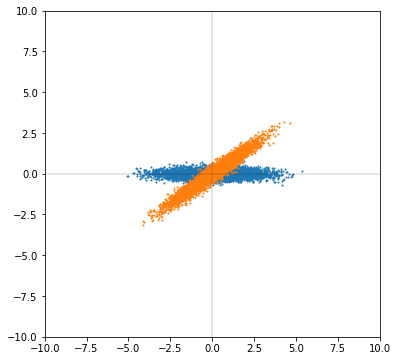

In [4]:
mu_1 = [0., 0.]
scale_1 = get_scale(phi=0.2 * math.pi, B=scale)
mvn_1 = ds.MultivariateNormalTriL(loc=mu_1, scale_tril=scale_1)

with tf.Session() as sess:
    samples_1 = sess.run(mvn_1.sample(5000))

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1.)
plt.scatter(samples_1[:, 0], samples_1[:, 1], s=1.)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()

We can also change their means to make them not be centered around $[0,0]$. For example, their means could be located on a circle whose center is $[0,0]$.

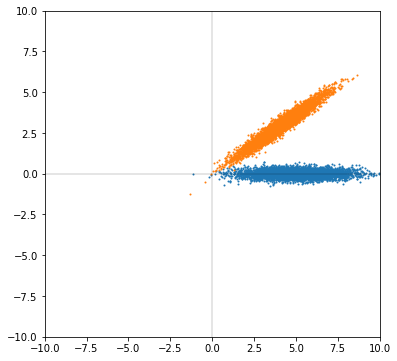

In [5]:
def get_mu(r, phi):
    x = r * tf.cos(phi)
    y = r * tf.sin(phi)
    return [x, y]

r = 5.
mu_0 = [r, 0.]
cov_0 = [[2.5, 0.],
        [0., 0.04]]

# The first Gaussian
scale_0 = tf.cholesky(cov_0)
mvn_0 = ds.MultivariateNormalTriL(loc=mu_0, scale_tril=scale_0)

# The second Gaussian
mu_1 = get_mu(r, 0.2 * math.pi)
scale_1 = get_scale(phi=0.2 * math.pi, B=scale_0)
mvn_1 = ds.MultivariateNormalTriL(loc=mu_1, scale_tril=scale_1)

with tf.Session() as sess:
    samples_0 = sess.run(mvn_0.sample(5000))
    samples_1 = sess.run(mvn_1.sample(5000))

plt.figure(figsize=(6, 6))
plt.scatter(samples_0[:, 0], samples_0[:, 1], s=1.)
plt.scatter(samples_1[:, 0], samples_1[:, 1], s=1.)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()

Similarly, we can draw more Gaussian distribution following the above procedure. We define a class to assemble the above all.

In [6]:
# Define a class 
class Gaussian_mixture(object):
    
    def __init__(self, theta, phi, r, initial_cov, num_gaussians):
        """
        The first Gaussian is specified by N(mu_0, Sigma_0), where mu_0 = [rcos(theta), rsin(theta)].
        Each we rotate it for phi to get a distribution. num_gaussians is the number of rotations.
        """
        self.theta = theta
        self.phi = phi
        self.r = r
        self.scale_0 = tf.cholesky(initial_cov)
        self.num_gaussians = num_gaussians
        self.mixture_model = self.get_mixture_model()
    
    def get_mixture_model(self):
        """
        ds.Mixture in TensorFlow requires a Categorical dist. to determine which individual dist. is 
        used for generating a sample, 'components' is a list of different classes defined from 
        tf.contrib.distributions
        """
        prob = 1. / self.num_gaussians
        probs = [prob for i in range(self.num_gaussians)]
        
        mus = self.get_mus()
        scales = self.get_scale_matrices()
        gaussians = [ds.MultivariateNormalTriL(loc=mus[i], scale_tril=scales[i]) for i in range(self.num_gaussians)]
        
        mixture = ds.Mixture(cat=ds.Categorical(probs=probs), components=gaussians)
        
        return mixture
    
    def _get_scale(self, phi, B):
        A = [[tf.cos(phi), -tf.sin(phi)],
         [tf.sin(phi), tf.cos(phi)]]
        AB = tf.matmul(A, B)
        cov = tf.matmul(AB, tf.transpose(AB))
        scale = tf.cholesky(cov)
        return scale
    
    def get_mus(self):
        mus = []
        for i in range(self.num_gaussians):
            mu = [self.r * tf.cos(self.theta + i * self.phi), self.r * tf.sin(self.theta + i * self.phi)]
            mus.append(mu)
        return mus
    
    def get_scale_matrices(self):
        scale_matrices = []
        for i in range(self.num_gaussians):
            scale_matrices.append(self._get_scale(i * self.phi, self.scale_0))
        return scale_matrices
    
    def get_samples(self, number):
        with tf.Session() as sess:
            samples = sess.run(self.mixture_model.sample(number))
        return samples
    
    def plot(self, num_samples, color):
        samples = self.get_samples(num_samples)
        figure = plt.scatter(samples[:, 0], samples[:, 1], s=1., color=color)
        return figure

#### Use the above class to sample a mixture model of 10 2D Gaussians

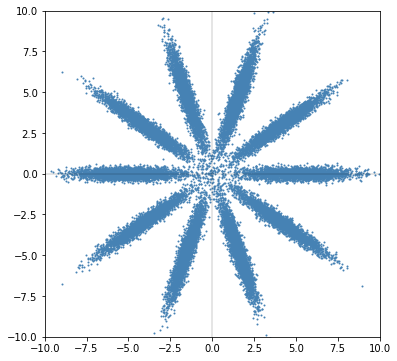

In [7]:
mixture_model = Gaussian_mixture(theta=0., phi=0.2 * math.pi, r=5., initial_cov=[[2.5, 0.], [0., 0.04]], num_gaussians=10)
plt.figure(figsize=(6, 6))
mixture_model.plot(30000, 'steelblue')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.axhline(y=0, color='k', linewidth=0.2)
plt.axvline(x=0, color='k', linewidth=0.2)
plt.show()